# AudioData

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from wavenet.audiodata import AudioData
from wavenet.utils import list_files

%matplotlib inline

x_len = 100
filelist = list_files('./audio')
ad = AudioData(filelist, x_len)

### __load_audio_from_wav

In [2]:
audio, dtype, sr = ad._load_audio_from_wav(filelist[0])

print('File: {}, dtype: {}, sample rate: {}'.format(
    filelist[0], dtype, sr))
print('Span: [{}, {}]'.format(np.min(audio), np.max(audio)))
print('Length: {} ({:.04f} seconds)'.format(len(audio), len(audio) / sr))
print('# unique values: {}'.format(len(np.unique(audio))))

File: ./audio/072.wav, dtype: int16, sample rate: 44100
Span: [-29675.0, 28356.5]
Length: 10305792 (233.6914 seconds)
# unique values: 104147


### _extract_segment: 
#### using `start_idx`

Lengths from method: {x: 100, y: 50}
Lengths from test: {x: 100, y: 50}


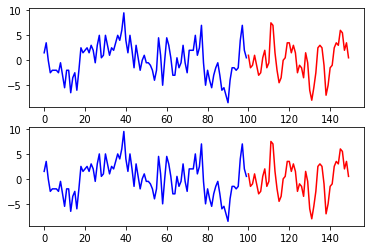

In [3]:
x_len = 100
y_len = 50
start_idx = 500
audio, _, _ = ad._load_audio_from_wav(filelist[0])
x, y = ad._extract_segment(audio, x_len, y_len, start_idx=start_idx)

# compare extracted to manually extracted example
x_man = audio[start_idx:start_idx + x_len]
y_man = audio[start_idx + x_len:start_idx + x_len + y_len]

print('Lengths from method: {{x: {}, y: {}}}'.format(len(x), len(y)))
print('Lengths from test: {{x: {}, y: {}}}'.format(len(x_man), len(y_man)))

plt.subplot(211)
plt.plot(range(x_len), x, 'b')
plt.plot(range(x_len, x_len + y_len), y, 'r')
plt.subplot(212)
plt.plot(range(x_len), x_man, 'b')
plt.plot(range(x_len, x_len + y_len), y_man, 'r')

### _extract segment
#### no `start_idx`

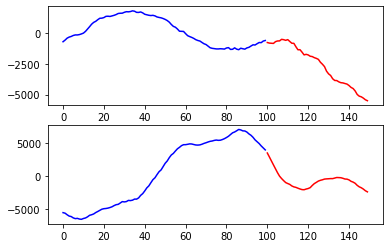

In [4]:
x_len = 100
y_len = 50
audio, _, _ = ad._load_audio_from_wav('./audio/001.wav')
x1, y1 = ad._extract_segment(audio, x_len, y_len)
x2, y2 = ad._extract_segment(audio, x_len, y_len)

# verify the two are different
plt.subplot(211)
plt.plot(range(x_len), x1, 'b')
plt.plot(range(x_len, x_len + y_len), y1, 'r')
plt.subplot(212)
plt.plot(range(x_len), x2, 'b')
plt.plot(range(x_len, x_len + y_len), y2, 'r')

### _to_tensor

In [5]:
x_len = 100
y_len = 50
audio, _, _ = ad._load_audio_from_wav('./audio/001.wav')
x, y = ad._extract_segment(audio, x_len, y_len)

x_solo = ad._to_tensor(x)
x_wy, y_wy = ad._to_tensor(x, y=y)

print('Before (x): {}, Shape: {}'.format(type(x), x.shape))
print('After (x-solo): {}, Shape: {}'.format(type(x_solo), x_solo.shape))
print('After (x): {}, Shape: {}'.format(type(x_wy), x_wy.shape))
print('')
print('Before (y): {}, Shape: {}'.format(type(y), y.shape))
print('After (y): {}, Shape: {}'.format(type(y_wy), y_wy.shape))

Before (x): <class 'numpy.ndarray'>, Shape: (100,)
After (x-solo): <class 'torch.Tensor'>, Shape: torch.Size([1, 100])
After (x): <class 'torch.Tensor'>, Shape: torch.Size([1, 100])

Before (y): <class 'numpy.ndarray'>, Shape: (50,)
After (y): <class 'torch.Tensor'>, Shape: torch.Size([50])


### _quantize

In [6]:
x_len = 100
y_len = 50
audio, _, _ = ad._load_audio_from_wav('./audio/001.wav')
x, y = ad._extract_segment(audio, x_len, y_len)

x = ad.encoder.encode(x)
y = ad.encoder.encode(y)
x_q = ad._quantize(x)
y_q = ad._quantize(y, label=True)

print('Before (x): span: {}, # unique: {}'.format(
    (np.min(x), np.max(x)), len(np.unique(x))))
print('After (x): span: {}, # unique: {}'.format(
    (np.min(x_q), np.max(x_q)), len(np.unique(x_q))))
print('Before (y): span: {}, # unique: {}'.format(
    (np.min(y), np.max(y)), len(np.unique(y))))
print('After (y): span: {}, # unique: {}'.format(
    (np.min(y_q), np.max(y_q)), len(np.unique(y_q))))

Before (x): span: (-0.49488473, 0.63558173), # unique: 100
After (x): span: (-0.4980392156862745, 0.6313725490196078), # unique: 64
Before (y): span: (0.42751455, 0.6306768), # unique: 50
After (y): span: (182, 207), # unique: 23


### save_wav

Original: length: 1100160, dtype: int16, sample rate: 44100
Saved: length: 1100160, dtype: int16, sample rate: 44100


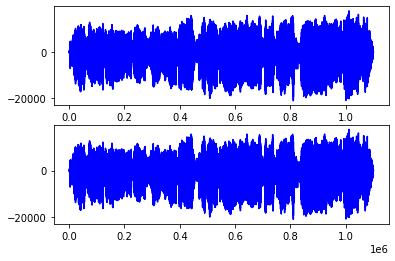

In [7]:
filename_out = './tmp.wav'
audio, dtype, sr = ad._load_audio_from_wav('./audio/001.wav')
print('Original: length: {}, dtype: {}, sample rate: {}'.format(
    len(audio), dtype, sr))

ad.save_wav(filename_out, audio, sr)

audio_out, dtype_out, sr_out = ad._load_audio_from_wav(filename_out)
print('Saved: length: {}, dtype: {}, sample rate: {}'.format(
    len(audio_out), dtype_out, sr_out))

plt.subplot(211)
plt.plot(range(len(audio)), audio, 'b')
plt.subplot(212)
plt.plot(range(len(audio_out)), audio_out, 'b')

### label2value

In [8]:
x_len = 100
y_len = 50
audio, _, _ = ad._load_audio_from_wav('./audio/001.wav')
x, y = ad._extract_segment(audio, x_len, y_len)

y_enc = ad.encoder.encode(y)
y_q = ad._quantize(y_enc, label=True)

y_val = ad.label2value(y_q)

idxs = np.random.randint(y_len, size=6)
print('Before: {}'.format(y_enc[idxs]))
print('Quant: {}'.format(y_q[idxs]))
print('After: {}'.format(y_val[idxs]))

Before: [-0.64214003 -0.7369642   0.42090523 -0.48873514 -0.46865776 -0.3147423 ]
Quant: [ 45  33 181  65  67  87]
After: [-0.64705882 -0.74117647  0.41960784 -0.49019608 -0.4745098  -0.31764706]


### preprocess

In [9]:
x_len = 100
y_len = 50
audio, _, _ = ad._load_audio_from_wav('./audio/001.wav')
x, y = ad._extract_segment(audio, x_len, y_len)

x_solo = ad.preprocess(x)
x_wy, y_wy = ad.preprocess(x, y=y)

print('Before (x): span: {}, # unique: {}'.format(
    (np.min(x), np.max(x)), len(np.unique(x))))
print('After (x-solo): span: {}, # unique: {}'.format(
    (np.min(x_solo), np.max(x_solo)), len(np.unique(x_solo))))
print('After (x): span: {}, # unique: {}'.format(
    (np.min(x_wy), np.max(x_wy)), len(np.unique(x_wy))))
print('')
print('Before (y): span: {}, # unique: {}'.format(
    (np.min(y), np.max(y)), len(np.unique(y))))
print('After (y): span: {}, # unique: {}'.format(
    (np.min(y_wy), np.max(y_wy)), len(np.unique(y_wy))))

Before (x): span: (-11420.0, 6571.0), # unique: 100
After (x-solo): span: (-0.8117647058823529, 0.7098039215686274), # unique: 68
After (x): span: (-0.8117647058823529, 0.7098039215686274), # unique: 68

Before (y): span: (-12288.0, 6612.5), # unique: 50
After (y): span: (22, 218), # unique: 39


# MuEncoder

In [10]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from wavenet.audiodata import AudioData

%matplotlib inline

x_len = 100
filelist = ['./audio/001.wav']
ad = AudioData(filelist, x_len)


### normalize

In [11]:
audio, dtype, sr = ad._load_audio_from_wav(filelist[0])
print('x: span: {}, # unique: {}'.format(
    (np.min(audio), np.max(audio)), len(np.unique(audio))))

# specify span using strings
x_s_dr = ad.encoder.normalize(audio, span='datarange')
x_s_mm = ad.encoder.normalize(audio, span='minmax')
print('span="datarange": span: {}, # unique: {}'.format(
    (np.min(x_s_dr), np.max(x_s_dr)), len(np.unique(x_s_dr))))
print('span="minmax": span: {}, # unique: {}'.format(
    (np.min(x_s_mm), np.max(x_s_mm)), len(np.unique(x_s_mm))))

# specify span using span=(min, max)
x_set = ad.encoder.normalize(audio, span=(-20000, 20000))
print('span=span: span: {}, # unique: {}'.format(
    (np.min(x_set), np.max(x_set)), len(np.unique(x_set))))

# span=None, default to datarange
x_dr = ad.encoder.normalize(audio)
print('span=None: span: {}, # unique: {}'.format(
    (np.min(x_dr), np.max(x_dr)), len(np.unique(x_dr))))

# span=None and datarange=None
ad_copy = copy.deepcopy(ad)
ad_copy.encoder.datarange = None
x_mm = ad_copy.encoder.normalize(audio)
print('span=None, datarange=None: span: {}, # unique: {}'.format(
    (np.min(x_mm), np.max(x_mm)), len(np.unique(x_mm))))

x: span: (-20983.0, 17731.0), # unique: 57821
span="datarange": span: (-0.64034486, 0.54113066), # unique: 57821
span="minmax": span: (-1.0, 1.0), # unique: 57821
span=span: span: (-1.04915, 0.88654995), # unique: 57821
span=None: span: (-0.64034486, 0.54113066), # unique: 57821
span=None, datarange=None: span: (-1.0, 1.0), # unique: 57821


### expand

x: span: (-20983.0, 17731.0), # unique: 57821
x normed: span: (-0.64034486, 0.54113066), # unique: 57821
x expanded: span: (-20983.0, 17731.0), # unique: 57821


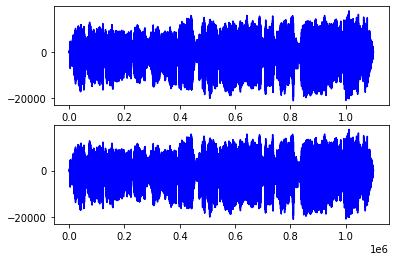

In [12]:
x, _, _ = ad._load_audio_from_wav(filelist[0])
print('x: span: {}, # unique: {}'.format(
    (np.min(x), np.max(x)), len(np.unique(x))))

x_norm = ad.encoder.normalize(x)
print('x normed: span: {}, # unique: {}'.format(
    (np.min(x_norm), np.max(x_norm)), len(np.unique(x_norm))))

x_expand = ad.encoder.expand(x_norm)
print('x expanded: span: {}, # unique: {}'.format(
    (np.min(x_expand), np.max(x_expand)), len(np.unique(x_expand))))

plt.subplot(211)
plt.plot(range(len(x)), x, 'b')
plt.subplot(212)
plt.plot(range(len(x_expand)), x_expand, 'b')

### encode & decode

x: span: (-20983.0, 17731.0), # unique: 57821
x encoded: span: (-0.9200103, 0.8898525), # unique: 57821
x decoded: span: (-20982.998, 17731.004), # unique: 57821


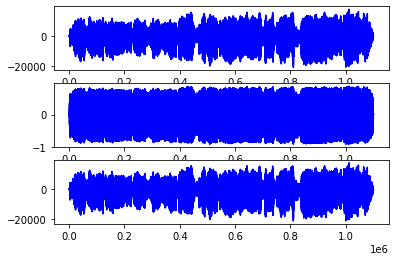

In [13]:
x, _, _ = ad._load_audio_from_wav(filelist[0])
print('x: span: {}, # unique: {}'.format(
    (np.min(x), np.max(x)), len(np.unique(x))))

x_enc = ad.encoder.encode(x)
print('x encoded: span: {}, # unique: {}'.format(
    (np.min(x_enc), np.max(x_enc)), len(np.unique(x_enc))))

x_dec = ad.encoder.decode(x_enc)
print('x decoded: span: {}, # unique: {}'.format(
    (np.min(x_dec), np.max(x_dec)), len(np.unique(x_dec))))

plt.subplot(311)
plt.plot(range(len(x)), x, 'b')
plt.subplot(312)
plt.plot(range(len(x_enc)), x_enc, 'b')
plt.subplot(313)
plt.plot(range(len(x_dec)), x_dec, 'b')

# Model

In [4]:
import os
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

from wavenet.audiodata import AudioData, AudioLoader
from wavenet.models import Model

%matplotlib inline

x_len = 2**10
num_classes = 256
num_layers = 9
num_blocks = 2
num_hidden = 128
kernel_size = 2
learn_rate = 0.001
step_size = 50
gamma = 0.5
batch_size = 32
num_workers = 1
num_epochs = 100

# filelist = ['./audio/001.wav', './audio/061.wav', './audio/072.wav']
filelist = ['./audio/001.wav']
dataset = AudioData(filelist, x_len, num_classes=num_classes, 
                    store_tracks=True)
dataloader = AudioLoader(dataset, batch_size=batch_size, 
                         num_workers=num_workers)
wave_model = Model(x_len, num_channels=1, num_classes=num_classes, 
                   num_blocks=num_blocks, num_layers=num_layers,
                   num_hidden=num_hidden, kernel_size=kernel_size)

receptive_field: 1023
Output width: 2


### set_device

In [5]:
print('Original device: {}'.format(wave_model.device))

wave_model.set_device(torch.device('cpu'))
print('Manually set device: {}'.format(wave_model.device))

wave_model.set_device()
print('Auto set device: {}'.format(wave_model.device))

import torch
torch.get_num_threads()

Original device: cpu
Manually set device: cpu
Auto set device: cpu


4

### train

In [ ]:
wave_model.criterion = nn.CrossEntropyLoss()
wave_model.optimizer = optim.Adam(wave_model.parameters(), 
                                  lr=learn_rate)
# wave_model.scheduler = optim.lr_scheduler.StepLR(wave_model.optimizer, 
#                                                  step_size=step_size, 
#                                                  gamma=gamma)

wave_model.scheduler = optim.lr_scheduler.LambdaLR(wave_model.optimizer, 
                                                 lambda epoch: 1)

wave_model.train(dataloader, num_epochs=num_epochs, disp_interval=1, use_visdom=True)

Setting up a new session...


Epoch 1 / 100
Learning Rate: [0.001]
Training Loss: 5.108383438803933
----------

Saving model data to file: /tmp/wavenet_qv_6pyn9
Epoch 2 / 100
Learning Rate: [0.001]
Training Loss: 4.341211116675175
----------

Saving model data to file: /tmp/wavenet_8l3s__aa
Epoch 3 / 100
Learning Rate: [0.001]
Training Loss: 3.844628615812822
----------

Saving model data to file: /tmp/wavenet__hhwu4d4


In [17]:
torch.save(wave_model.state_dict(), "model-")

# Generator

In [18]:
import os
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

from wavenet.audiodata import AudioData, AudioLoader
from wavenet.models import Model, Generator

%matplotlib inline

x_len = 2**10
num_classes = 256
num_layers = 9
num_blocks = 2
num_hidden = 128
kernel_size = 2
learn_rate = 0.001
step_size = 50
gamma = 0.5
batch_size = 8
num_workers = 1
num_epochs = 10

# x_len = 2**8
# num_classes = 256
# num_layers = 7
# num_blocks = 2
# num_hidden = 128
# kernel_size = 2
# learn_rate = 0.001
# step_size = 50
# gamma = 0.5
# batch_size = 8
# num_workers = 1
# num_epochs = 10
model_file = 'model-2.ct'

filelist = ['./audio/001.wav']
dataset = AudioData(filelist, x_len, num_classes=num_classes, 
                    store_tracks=True)
dataloader = AudioLoader(dataset, batch_size=batch_size, 
                         num_workers=num_workers)
wave_model = Model(x_len, num_channels=1, num_classes=num_classes, 
                   num_blocks=num_blocks, num_layers=num_layers,
                   num_hidden=num_hidden, kernel_size=kernel_size)

if os.path.isfile(model_file):
    wave_model.load_state_dict(torch.load(model_file))
else:
    raise Exception("should have model")
    wave_model.criterion = nn.CrossEntropyLoss()
    wave_model.optimizer = optim.Adam(wave_model.parameters(), 
                                      lr=learn_rate)
    wave_model.scheduler = optim.lr_scheduler.StepLR(wave_model.optimizer, 
                                                     step_size=step_size, 
                                                     gamma=gamma)

    wave_model.set_device(torch.device('cpu'))
    wave_model.train(dataloader, num_epochs=num_epochs, disp_interval=1)
    torch.save(wave_model.state_dict(), model_file)

wave_generator = Generator(wave_model, dataset)

receptive_field: 1023
Output width: 2


### _shift_insert

In [20]:
n_samples = 3
x = np.linspace(-2**15, 2**15, 6)
print('x:')
print('\tspan: {}, # unique: {}'.format(
    (np.min(x), np.max(x)), len(np.unique(x))))

x = dataset._to_tensor(dataset.preprocess(x))
x = torch.unsqueeze(x, 0)
print('\ttype: {}, shape: {}'.format(type(x), x.shape))
print('\tdata: {}'.format(x.data))

x_s = wave_generator._shift_insert(x, np.array([0]))
print('x shifted:')
print('\ttype: {}, shape: {}'.format(type(x_s), x_s.shape))
print('\tdata: {}'.format(x_s.data))

x:
	span: (-32768.0, 32768.0), # unique: 6
	type: <class 'torch.Tensor'>, shape: torch.Size([1, 1, 6])
	data: tensor([[[-1.0000, -0.9137, -0.7176,  0.7098,  0.9059,  1.0000]]])
x shifted:
	type: <class 'torch.Tensor'>, shape: torch.Size([1, 1, 6])
	data: tensor([[[-0.9137, -0.7176,  0.7098,  0.9059,  1.0000,  0.0000]]])


### tensor2numpy

In [21]:
x, _, _ = dataset._load_audio_from_wav(filelist[0])
x = dataset._to_tensor(dataset.preprocess(x))
x = torch.unsqueeze(x, 0)
print('x: type: {}, shape: {}'.format(type(x), x.shape))

x_np = wave_generator.tensor2numpy(x)
print('x numpy: type: {}, shape: {}'.format(type(x_np), x_np.shape))

x: type: <class 'torch.Tensor'>, shape: torch.Size([1, 1, 1100160])
x numpy: type: <class 'numpy.ndarray'>, shape: (1, 1, 1100160)


### predict

In [22]:
x, _, _ = dataset._load_audio_from_wav(filelist[0])
x = dataset._to_tensor(dataset.preprocess(x))
x = torch.unsqueeze(x, 0)

y = wave_generator.predict(x)
print('y: type: {}, shape: {}'.format(type(y), y.shape))

RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at /pytorch/aten/src/TH/THGeneral.cpp:204

### run

Sample 0 / 44100
Sample 10 / 44100
Sample 20 / 44100
Sample 30 / 44100
Sample 40 / 44100
Sample 50 / 44100
Sample 60 / 44100
Sample 70 / 44100
Sample 80 / 44100
Sample 90 / 44100
Sample 100 / 44100
Sample 110 / 44100
Sample 120 / 44100
Sample 130 / 44100
Sample 140 / 44100
Sample 150 / 44100
Sample 160 / 44100
Sample 170 / 44100
Sample 180 / 44100
Sample 190 / 44100
Sample 200 / 44100
Sample 210 / 44100
Sample 220 / 44100
Sample 230 / 44100
Sample 240 / 44100
Sample 250 / 44100
Sample 260 / 44100
Sample 270 / 44100
Sample 280 / 44100
Sample 290 / 44100
Sample 300 / 44100
Sample 310 / 44100
Sample 320 / 44100
Sample 330 / 44100
Sample 340 / 44100
Sample 350 / 44100
Sample 360 / 44100
Sample 370 / 44100
Sample 380 / 44100
Sample 390 / 44100
Sample 400 / 44100
Sample 410 / 44100
Sample 420 / 44100
Sample 430 / 44100
Sample 440 / 44100
Sample 450 / 44100
Sample 460 / 44100
Sample 470 / 44100
Sample 480 / 44100
Sample 490 / 44100
Sample 500 / 44100
Sample 510 / 44100
Sample 520 / 44100
Samp

Sample 4160 / 44100
Sample 4170 / 44100
Sample 4180 / 44100
Sample 4190 / 44100
Sample 4200 / 44100
Sample 4210 / 44100
Sample 4220 / 44100
Sample 4230 / 44100
Sample 4240 / 44100
Sample 4250 / 44100
Sample 4260 / 44100
Sample 4270 / 44100
Sample 4280 / 44100
Sample 4290 / 44100
Sample 4300 / 44100
Sample 4310 / 44100
Sample 4320 / 44100
Sample 4330 / 44100
Sample 4340 / 44100
Sample 4350 / 44100
Sample 4360 / 44100
Sample 4370 / 44100
Sample 4380 / 44100
Sample 4390 / 44100
Sample 4400 / 44100
Sample 4410 / 44100
Sample 4420 / 44100
Sample 4430 / 44100
Sample 4440 / 44100
Sample 4450 / 44100
Sample 4460 / 44100
Sample 4470 / 44100
Sample 4480 / 44100
Sample 4490 / 44100
Sample 4500 / 44100
Sample 4510 / 44100
Sample 4520 / 44100
Sample 4530 / 44100
Sample 4540 / 44100
Sample 4550 / 44100
Sample 4560 / 44100
Sample 4570 / 44100
Sample 4580 / 44100
Sample 4590 / 44100
Sample 4600 / 44100
Sample 4610 / 44100
Sample 4620 / 44100
Sample 4630 / 44100
Sample 4640 / 44100
Sample 4650 / 44100


Sample 8260 / 44100
Sample 8270 / 44100
Sample 8280 / 44100
Sample 8290 / 44100
Sample 8300 / 44100
Sample 8310 / 44100
Sample 8320 / 44100
Sample 8330 / 44100
Sample 8340 / 44100
Sample 8350 / 44100
Sample 8360 / 44100
Sample 8370 / 44100
Sample 8380 / 44100
Sample 8390 / 44100
Sample 8400 / 44100
Sample 8410 / 44100
Sample 8420 / 44100
Sample 8430 / 44100
Sample 8440 / 44100
Sample 8450 / 44100
Sample 8460 / 44100
Sample 8470 / 44100
Sample 8480 / 44100
Sample 8490 / 44100
Sample 8500 / 44100
Sample 8510 / 44100
Sample 8520 / 44100
Sample 8530 / 44100
Sample 8540 / 44100
Sample 8550 / 44100
Sample 8560 / 44100
Sample 8570 / 44100
Sample 8580 / 44100
Sample 8590 / 44100
Sample 8600 / 44100
Sample 8610 / 44100
Sample 8620 / 44100
Sample 8630 / 44100
Sample 8640 / 44100
Sample 8650 / 44100
Sample 8660 / 44100
Sample 8670 / 44100
Sample 8680 / 44100
Sample 8690 / 44100
Sample 8700 / 44100
Sample 8710 / 44100
Sample 8720 / 44100
Sample 8730 / 44100
Sample 8740 / 44100
Sample 8750 / 44100


Sample 12250 / 44100
Sample 12260 / 44100
Sample 12270 / 44100
Sample 12280 / 44100
Sample 12290 / 44100
Sample 12300 / 44100
Sample 12310 / 44100
Sample 12320 / 44100
Sample 12330 / 44100
Sample 12340 / 44100
Sample 12350 / 44100
Sample 12360 / 44100
Sample 12370 / 44100
Sample 12380 / 44100
Sample 12390 / 44100
Sample 12400 / 44100
Sample 12410 / 44100
Sample 12420 / 44100
Sample 12430 / 44100
Sample 12440 / 44100
Sample 12450 / 44100
Sample 12460 / 44100
Sample 12470 / 44100
Sample 12480 / 44100
Sample 12490 / 44100
Sample 12500 / 44100
Sample 12510 / 44100
Sample 12520 / 44100
Sample 12530 / 44100
Sample 12540 / 44100
Sample 12550 / 44100
Sample 12560 / 44100
Sample 12570 / 44100
Sample 12580 / 44100
Sample 12590 / 44100
Sample 12600 / 44100
Sample 12610 / 44100
Sample 12620 / 44100
Sample 12630 / 44100
Sample 12640 / 44100
Sample 12650 / 44100
Sample 12660 / 44100
Sample 12670 / 44100
Sample 12680 / 44100
Sample 12690 / 44100
Sample 12700 / 44100
Sample 12710 / 44100
Sample 12720 

Sample 16160 / 44100
Sample 16170 / 44100
Sample 16180 / 44100
Sample 16190 / 44100
Sample 16200 / 44100
Sample 16210 / 44100
Sample 16220 / 44100
Sample 16230 / 44100
Sample 16240 / 44100
Sample 16250 / 44100
Sample 16260 / 44100
Sample 16270 / 44100
Sample 16280 / 44100
Sample 16290 / 44100
Sample 16300 / 44100
Sample 16310 / 44100
Sample 16320 / 44100
Sample 16330 / 44100
Sample 16340 / 44100
Sample 16350 / 44100
Sample 16360 / 44100
Sample 16370 / 44100
Sample 16380 / 44100
Sample 16390 / 44100
Sample 16400 / 44100
Sample 16410 / 44100
Sample 16420 / 44100
Sample 16430 / 44100
Sample 16440 / 44100
Sample 16450 / 44100
Sample 16460 / 44100
Sample 16470 / 44100
Sample 16480 / 44100
Sample 16490 / 44100
Sample 16500 / 44100
Sample 16510 / 44100
Sample 16520 / 44100
Sample 16530 / 44100
Sample 16540 / 44100
Sample 16550 / 44100
Sample 16560 / 44100
Sample 16570 / 44100
Sample 16580 / 44100
Sample 16590 / 44100
Sample 16600 / 44100
Sample 16610 / 44100
Sample 16620 / 44100
Sample 16630 

Sample 20070 / 44100
Sample 20080 / 44100
Sample 20090 / 44100
Sample 20100 / 44100
Sample 20110 / 44100
Sample 20120 / 44100
Sample 20130 / 44100
Sample 20140 / 44100
Sample 20150 / 44100
Sample 20160 / 44100
Sample 20170 / 44100
Sample 20180 / 44100
Sample 20190 / 44100
Sample 20200 / 44100
Sample 20210 / 44100
Sample 20220 / 44100
Sample 20230 / 44100
Sample 20240 / 44100
Sample 20250 / 44100
Sample 20260 / 44100
Sample 20270 / 44100
Sample 20280 / 44100
Sample 20290 / 44100
Sample 20300 / 44100
Sample 20310 / 44100
Sample 20320 / 44100
Sample 20330 / 44100
Sample 20340 / 44100
Sample 20350 / 44100
Sample 20360 / 44100
Sample 20370 / 44100
Sample 20380 / 44100
Sample 20390 / 44100
Sample 20400 / 44100
Sample 20410 / 44100
Sample 20420 / 44100
Sample 20430 / 44100
Sample 20440 / 44100
Sample 20450 / 44100
Sample 20460 / 44100
Sample 20470 / 44100
Sample 20480 / 44100
Sample 20490 / 44100
Sample 20500 / 44100
Sample 20510 / 44100
Sample 20520 / 44100
Sample 20530 / 44100
Sample 20540 

Sample 23980 / 44100
Sample 23990 / 44100
Sample 24000 / 44100
Sample 24010 / 44100
Sample 24020 / 44100
Sample 24030 / 44100
Sample 24040 / 44100
Sample 24050 / 44100
Sample 24060 / 44100
Sample 24070 / 44100
Sample 24080 / 44100
Sample 24090 / 44100
Sample 24100 / 44100
Sample 24110 / 44100
Sample 24120 / 44100
Sample 24130 / 44100
Sample 24140 / 44100
Sample 24150 / 44100
Sample 24160 / 44100
Sample 24170 / 44100
Sample 24180 / 44100
Sample 24190 / 44100
Sample 24200 / 44100
Sample 24210 / 44100
Sample 24220 / 44100
Sample 24230 / 44100
Sample 24240 / 44100
Sample 24250 / 44100
Sample 24260 / 44100
Sample 24270 / 44100
Sample 24280 / 44100
Sample 24290 / 44100
Sample 24300 / 44100
Sample 24310 / 44100
Sample 24320 / 44100
Sample 24330 / 44100
Sample 24340 / 44100
Sample 24350 / 44100
Sample 24360 / 44100
Sample 24370 / 44100
Sample 24380 / 44100
Sample 24390 / 44100
Sample 24400 / 44100
Sample 24410 / 44100
Sample 24420 / 44100
Sample 24430 / 44100
Sample 24440 / 44100
Sample 24450 

Sample 27890 / 44100
Sample 27900 / 44100
Sample 27910 / 44100
Sample 27920 / 44100
Sample 27930 / 44100
Sample 27940 / 44100
Sample 27950 / 44100
Sample 27960 / 44100
Sample 27970 / 44100
Sample 27980 / 44100
Sample 27990 / 44100
Sample 28000 / 44100
Sample 28010 / 44100
Sample 28020 / 44100
Sample 28030 / 44100
Sample 28040 / 44100
Sample 28050 / 44100
Sample 28060 / 44100
Sample 28070 / 44100
Sample 28080 / 44100
Sample 28090 / 44100
Sample 28100 / 44100
Sample 28110 / 44100
Sample 28120 / 44100
Sample 28130 / 44100
Sample 28140 / 44100
Sample 28150 / 44100
Sample 28160 / 44100
Sample 28170 / 44100
Sample 28180 / 44100
Sample 28190 / 44100
Sample 28200 / 44100
Sample 28210 / 44100
Sample 28220 / 44100
Sample 28230 / 44100
Sample 28240 / 44100
Sample 28250 / 44100
Sample 28260 / 44100
Sample 28270 / 44100
Sample 28280 / 44100
Sample 28290 / 44100
Sample 28300 / 44100
Sample 28310 / 44100
Sample 28320 / 44100
Sample 28330 / 44100
Sample 28340 / 44100
Sample 28350 / 44100
Sample 28360 

Sample 31800 / 44100
Sample 31810 / 44100
Sample 31820 / 44100
Sample 31830 / 44100
Sample 31840 / 44100
Sample 31850 / 44100
Sample 31860 / 44100
Sample 31870 / 44100
Sample 31880 / 44100
Sample 31890 / 44100
Sample 31900 / 44100
Sample 31910 / 44100
Sample 31920 / 44100
Sample 31930 / 44100
Sample 31940 / 44100
Sample 31950 / 44100
Sample 31960 / 44100
Sample 31970 / 44100
Sample 31980 / 44100
Sample 31990 / 44100
Sample 32000 / 44100
Sample 32010 / 44100
Sample 32020 / 44100
Sample 32030 / 44100
Sample 32040 / 44100
Sample 32050 / 44100
Sample 32060 / 44100
Sample 32070 / 44100
Sample 32080 / 44100
Sample 32090 / 44100
Sample 32100 / 44100
Sample 32110 / 44100
Sample 32120 / 44100
Sample 32130 / 44100
Sample 32140 / 44100
Sample 32150 / 44100
Sample 32160 / 44100
Sample 32170 / 44100
Sample 32180 / 44100
Sample 32190 / 44100
Sample 32200 / 44100
Sample 32210 / 44100
Sample 32220 / 44100
Sample 32230 / 44100
Sample 32240 / 44100
Sample 32250 / 44100
Sample 32260 / 44100
Sample 32270 

Sample 35710 / 44100
Sample 35720 / 44100
Sample 35730 / 44100
Sample 35740 / 44100
Sample 35750 / 44100
Sample 35760 / 44100
Sample 35770 / 44100
Sample 35780 / 44100
Sample 35790 / 44100
Sample 35800 / 44100
Sample 35810 / 44100
Sample 35820 / 44100
Sample 35830 / 44100
Sample 35840 / 44100
Sample 35850 / 44100
Sample 35860 / 44100
Sample 35870 / 44100
Sample 35880 / 44100
Sample 35890 / 44100
Sample 35900 / 44100
Sample 35910 / 44100
Sample 35920 / 44100
Sample 35930 / 44100
Sample 35940 / 44100
Sample 35950 / 44100
Sample 35960 / 44100
Sample 35970 / 44100
Sample 35980 / 44100
Sample 35990 / 44100
Sample 36000 / 44100
Sample 36010 / 44100
Sample 36020 / 44100
Sample 36030 / 44100
Sample 36040 / 44100
Sample 36050 / 44100
Sample 36060 / 44100
Sample 36070 / 44100
Sample 36080 / 44100
Sample 36090 / 44100
Sample 36100 / 44100
Sample 36110 / 44100
Sample 36120 / 44100
Sample 36130 / 44100
Sample 36140 / 44100
Sample 36150 / 44100
Sample 36160 / 44100
Sample 36170 / 44100
Sample 36180 

Sample 39620 / 44100
Sample 39630 / 44100
Sample 39640 / 44100
Sample 39650 / 44100
Sample 39660 / 44100
Sample 39670 / 44100
Sample 39680 / 44100
Sample 39690 / 44100
Sample 39700 / 44100
Sample 39710 / 44100
Sample 39720 / 44100
Sample 39730 / 44100
Sample 39740 / 44100
Sample 39750 / 44100
Sample 39760 / 44100
Sample 39770 / 44100
Sample 39780 / 44100
Sample 39790 / 44100
Sample 39800 / 44100
Sample 39810 / 44100
Sample 39820 / 44100
Sample 39830 / 44100
Sample 39840 / 44100
Sample 39850 / 44100
Sample 39860 / 44100
Sample 39870 / 44100
Sample 39880 / 44100
Sample 39890 / 44100
Sample 39900 / 44100
Sample 39910 / 44100
Sample 39920 / 44100
Sample 39930 / 44100
Sample 39940 / 44100
Sample 39950 / 44100
Sample 39960 / 44100
Sample 39970 / 44100
Sample 39980 / 44100
Sample 39990 / 44100
Sample 40000 / 44100
Sample 40010 / 44100
Sample 40020 / 44100
Sample 40030 / 44100
Sample 40040 / 44100
Sample 40050 / 44100
Sample 40060 / 44100
Sample 40070 / 44100
Sample 40080 / 44100
Sample 40090 

Sample 43530 / 44100
Sample 43540 / 44100
Sample 43550 / 44100
Sample 43560 / 44100
Sample 43570 / 44100
Sample 43580 / 44100
Sample 43590 / 44100
Sample 43600 / 44100
Sample 43610 / 44100
Sample 43620 / 44100
Sample 43630 / 44100
Sample 43640 / 44100
Sample 43650 / 44100
Sample 43660 / 44100
Sample 43670 / 44100
Sample 43680 / 44100
Sample 43690 / 44100
Sample 43700 / 44100
Sample 43710 / 44100
Sample 43720 / 44100
Sample 43730 / 44100
Sample 43740 / 44100
Sample 43750 / 44100
Sample 43760 / 44100
Sample 43770 / 44100
Sample 43780 / 44100
Sample 43790 / 44100
Sample 43800 / 44100
Sample 43810 / 44100
Sample 43820 / 44100
Sample 43830 / 44100
Sample 43840 / 44100
Sample 43850 / 44100
Sample 43860 / 44100
Sample 43870 / 44100
Sample 43880 / 44100
Sample 43890 / 44100
Sample 43900 / 44100
Sample 43910 / 44100
Sample 43920 / 44100
Sample 43930 / 44100
Sample 43940 / 44100
Sample 43950 / 44100
Sample 43960 / 44100
Sample 43970 / 44100
Sample 43980 / 44100
Sample 43990 / 44100
Sample 44000 

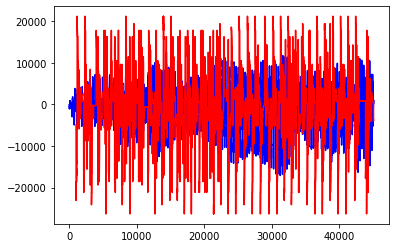

In [19]:
num_samples = 44100
start_idx = 10000

audio, _, _ = dataset._load_audio_from_wav(filelist[0])
x = audio[start_idx:start_idx + x_len]
x_samp = audio[start_idx:start_idx + x_len + num_samples]

y = wave_generator.run(x, num_samples, disp_interval=10)
print('y:')
print('\ntype: {}, shape: {}'.format(type(y), y.shape))
print('\nspan: {}, # unique: {}'.format(
    (np.min(y), np.max(y)), len(np.unique(y))))

plt.plot(range(x_len + num_samples), x_samp, 'b')
plt.plot(range(x_len, x_len + num_samples), y, 'r')

In [20]:
dataset.save_wav('./tmp-2.wav', y, dataloader.dataset.sample_rate)